In [1]:
from pathlib import Path
import os
import time
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

from data_loader import *
from model import *
from test import *


# pre-process
def pre_proc(tau, block):
    '''log(tau)'''
    tau   = np.array(tau)
    block = np.array(block)
    tau   = np.log(tau)
    return (tau, block)

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.array(tau)
    tau = np.exp(-np.exp(tau))
    return tau


# Path and data file name
folder  = Path.cwd().parent / 'Illustris3'
DM_name = ['DMdelta_Illustris3_L75_N600_v2.fits', 
            'vx_cic_Illustris3_L75_N600_v2.fits',
            'vy_cic_Illustris3_L75_N600_v2.fits',
            'vz_cic_Illustris3_L75_N600_v2.fits']
ske_name = 'spectra_Illustris3_N600_zaxis.npy'



# hyper parameters
train_insize = np.array([15, 15, 71]) # x, y, z respctively
train_ousize = np.array([5, 5, 5]) # x, y, z respctively
test_batch = 50
localtime_n = ['2019-11-15 04:39:02']

In [7]:
np.log10(50)

1.6989700043360187

In [11]:
print('{}, {:{:d}d}, {}'.format(4, 5,int(np.log10(50)+1), 6))

4,  5, 6


In [2]:
skey = np.load(folder/'spectra_Illustris3_N600_yaxis.npy')

In [5]:
skey = skey.reshape(600,600,600)

In [3]:
DM_general = load_DM(folder, DM_name)
# basic paramters
DM_param.pix  = len(DM_general[0])
DM_param.len  = 75 # in Mpc/h
DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h

In [4]:
DM_general = DM_general.transpose(0,3,1,2)

In [5]:
DM_general = DM_general[[0,3,1,2]]

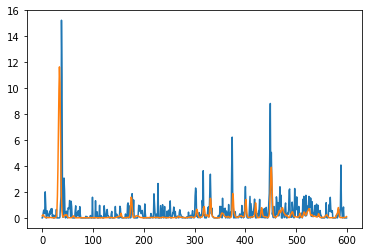

In [22]:
ii = np.random.randint(0, 600)
jj = np.random.randint(0, 600)
plt.plot(DM_general[0, ii, jj])
plt.plot(skey[ii, jj])

In [2]:
for localtime_i in localtime_n:
    localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')

    
    
    # device used to train the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', device)



    # load dark matter data
    print('Loading dark matter...')
    DM_general = load_DM(folder, DM_name)
    # basic paramters
    DM_param.pix  = len(DM_general[0])
    DM_param.len  = 75 # in Mpc/h
    DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
    # test
    if DM_general.shape[1]<train_insize.min():
        raise ValueError('DarkMatter cube size',
            DM_general.shape, 'is too small for train size', train_insize, '.')
    DM_general = torch.tensor(DM_general).float()


    # load skewers
    print('Loading skewers...')
    ske, block = load_skewers(folder, ske_name, train_ousize, DM_param)
    # basic parameters
    ske_len = int(ske.shape[-1])


    # divide the sample to training, validation set, and test set.
    print('Setting test set...')
    with open("id_seperate/id_seperate_%s.txt"\
              %time.strftime("%Y-%m-%d_%H:%M:%S", localtime), "r") as f:
        aa = f.readlines()
        id_seperate = np.array(list(aa[0][::3])).astype('int')
        del aa
    f.close()

    test_ske, test_block = load_test(ske, block, id_seperate,
                                     train_ousize, test_batch, pre_proc)
    del id_seperate


    # load model
    print('Loading model...')
    model = get_residual_network().float().to(device)
    model.load_state_dict(torch.load('params/params_%s.pkl'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    #model.load_state_dict(torch.load('params/HyPhy_%s'\
    #        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))



    # loss
    criterion = nn.SmoothL1Loss()


    # record starr time
    start_time = time.time()


    # start test
    print('Begin testing...')
    test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                            test_batch, train_insize, model, criterion, device, start_time)

    print("Test Summary: ")
    print("\tTest loss: {}".format(test_losses))
    
    # restore test skewers
    print('Restoring test skewers...')
    nz = (ske_len/train_ousize[2]).astype('int')
    test_ske = test_ske.numpy().reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
    xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
    ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
    mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
    test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
    test_ske  = toF_proc(test_ske)
    test_outp = toF_proc(test_outp)


    print('Plotting example skewers...')
    # generate comparison images
    folder_outp = Path.cwd()/'test_figs'/('%s'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    if not os.path.exists(folder_outp):
        os.makedirs(folder_outp)
    
    from scipy import constants as C
    v_end  = 0.02514741843009228 * C.speed_of_light / 1e3
    
    nrange = min(len(test_ske), 50)
    test_sp = np.arange(len(test_ske))
    np.random.seed(99)
    np.random.shuffle(test_sp)
    test_sp1 = test_sp[:int(nrange)].astype('int')
    test_sp2 = test_sp[int(nrange):].astype('int')
    
    accuracy = AverageMeter()
    rela_err = AverageMeter()
    accu_arr = np.zeros(len(test_ske))
    erro_arr = np.zeros(len(test_ske))
    

    # loop
    for i, ii in enumerate(test_sp1):
        print('Plotting {}/{}, x{}y{}.png...'\
                .format((i+1), nrange, test_block[ii,0], test_block[ii,1]))

        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

        accuracy_i, rela_err_i = test_plot(test_block_i, test_outp_i, test_ske_i, test_DM_i,
                                         v_end, folder_outp)
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
    
    print('Measuring accuracy of left skewers...')
    for i, ii in enumerate(test_sp2):
        
        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()
        
        accuracy_i, rela_err_i = test_accuracy(test_block_i, test_outp_i, test_ske_i,
                                         v_end, folder_outp)
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        
        
    fig, axes = plt.subplots(2,2,figsize=(12,9))
    axes[0,0].scatter(np.arange(len(test_ske)), accu_arr, alpha=0.5, color='grey')
    axes[0,0].hlines(y=accu_arr.mean(), xmin=0, xmax=len(test_ske), linestyle='--')
    axes[0,0].set_xticks([])
    axes[0,0].set_ylim([-0.1, 1.7])
    axes[0,0].set_ylabel('accuracy $m$', fontsize=18)

    axes[0,1].hist(accu_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,1].set_ylim(axes[0,1].get_ylim())
    p1 = axes[0,1].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,1].set_xlabel('accuracy $m$', fontsize=18)
    axes[0,1].set_ylabel('pdf of $m$', fontsize=18)
    customs = [p1]
    axes[0,1].legend(customs, ['average $m=%.4f$'%accu_arr.mean()], fontsize=14, loc=1)

    axes[1,0].scatter(np.arange(len(test_ske)), erro_arr, alpha=0.5, color='grey')
    axes[1,0].hlines(y=erro_arr.mean(), xmin=0, xmax=len(test_ske), linestyle='--')
    axes[1,0].set_xticks([])
    axes[1,0].set_ylim([-0.1, 1.7])
    axes[1,0].set_ylabel('error $s$', fontsize=18)

    axes[1,1].hist(erro_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[1,1].set_ylim(axes[0,1].get_ylim())
    p2 = axes[1,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[1,1].set_xlabel('accuracy $s$', fontsize=18)
    axes[1,1].set_ylabel('pdf of $s$', fontsize=18)
    customs = [p2]
    axes[1,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean()], fontsize=14, loc=1)

    plt.savefig(folder_outp / ('average.png'), dpi=300, bbox_inches='tight') 
    plt.close()
    
print('Finished test!')

Using device: cuda:0
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [100/480] Loss: 0.3417, Time: 21.7369
Step [200/480] Loss: 0.1122, Time: 41.2840
Step [300/480] Loss: 0.1183, Time: 60.2632
Step [400/480] Loss: 0.1223, Time: 79.0301
Test Summary: 
	Test loss: 0.1644236497581005
Restoring test skewers...
Plotting example skewers...
Plotting 1/50, x141y364.png...
Plotting 2/50, x50y185.png...
Plotting 3/50, x315y208.png...
Plotting 4/50, x430y240.png...
Plotting 5/50, x431y243.png...
Plotting 6/50, x70y103.png...
Plotting 7/50, x458y350.png...
Plotting 8/50, x471y380.png...
Plotting 9/50, x511y58.png...
Plotting 10/50, x294y245.png...
Plotting 11/50, x513y247.png...
Plotting 12/50, x54y343.png...
Plotting 13/50, x488y181.png...
Plotting 14/50, x308y197.png...
Plotting 15/50, x352y269.png...
Plotting 16/50, x510y259.png...
Plotting 17/50, x430y244.png...
Plotting 18/50, x39y524.png...
Plotting 19/50, x460y111.png...
Plotting 20/50, x

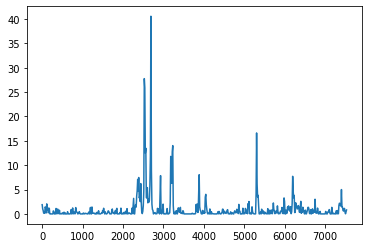

In [16]:
plt.plot(np.arange(600)/600*v_end, DM_general[0, 54, 343, :].numpy())

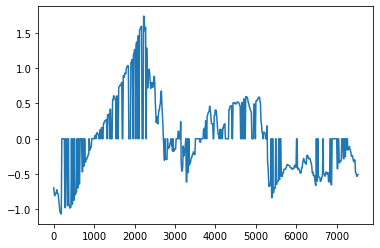

In [17]:
plt.plot(np.arange(600)/600*v_end, DM_general[3, 54, 343, :].numpy())

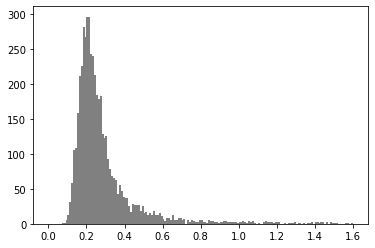

In [6]:
data = plt.hist(accu_arr, bins=np.arange(0, 1.61, 0.01), color='grey')

In [5]:
data[0], data[1]

(array([   0.,    7.,  315., 1143., 1286.,  798.,  430.,  246.,  145.,
         126.,   73.,   72.,   33.,   39.,   21.,   21.,   18.,   15.,
          16.,   10.,   13.,   11.,    7.,   11.,    6.,    5.,    3.,
           4.,    9.,    6.,    2.,    3.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ]))

In [13]:
alpha = accu_arr.mean()**2 / accu_arr.std(ddof=1)**2
beta  = accu_arr.mean() / accu_arr.std(ddof=1)**2

In [23]:
accu_arr.std()

5.813074550818238

In [59]:
np.random.gamma(alpha, 1/beta, size=len(test_ske))

array([6.20860953e-21, 4.89115581e-63, 8.62192430e-37, ...,
       1.09286685e-32, 1.17480909e-16, 3.01505719e-64])